# PIFuHD Demo: https://shunsukesaito.github.io/PIFuHD/

![](https://shunsukesaito.github.io/PIFuHD/resources/images/pifuhd.gif)

Made by [![Follow](https://img.shields.io/twitter/follow/psyth91?style=social)](https://twitter.com/psyth91)

To see how the model works, visit the project repository.

[![GitHub stars](https://img.shields.io/github/stars/facebookresearch/pifuhd?style=social)](https://github.com/facebookresearch/pifuhd)

## Note
Make sure that your runtime type is 'Python 3 with GPU acceleration'. To do so, go to Edit > Notebook settings > Hardware Accelerator > Select "GPU".

## More Info
- Paper: https://arxiv.org/pdf/2004.00452.pdf
- Repo: https://github.com/facebookresearch/pifuhd
- Project Page: https://shunsukesaito.github.io/PIFuHD/

## Requirements
- Python 3
- PyTorch tested on 1.4.0
- json
- PIL
- skimage
- tqdm
- numpy
- cv2

## Clone PIFuHD repository

In [ ]:
!git clone https://github.com/facebookresearch/pifuhd

Cloning into 'pifuhd'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 402.72 KiB | 3.91 MiB/s, done.
Resolving deltas: 100% (104/104), done.


## Configure input data

In [ ]:
cd /content/pifuhd/sample_images

/content/pifuhd/sample_images


**If you want to upload your own picture, run the next cell**. Otherwise, go to the next next cell. Currently PNG, JPEG files are supported.

In [ ]:
from google.colab import files

filename = list(files.upload().keys())[0]

Saving jonh-wick.jpg to jonh-wick.jpg


In [ ]:
import os

try:
  image_path = '/content/pifuhd/sample_images/%s' % filename
except:
  image_path = '/content/pifuhd/sample_images/test.png' # example image

print(image_path)
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name

/content/pifuhd/sample_images/jonh-wick.jpg


In [ ]:
cd /content

/content


## Preprocess (for cropping image)

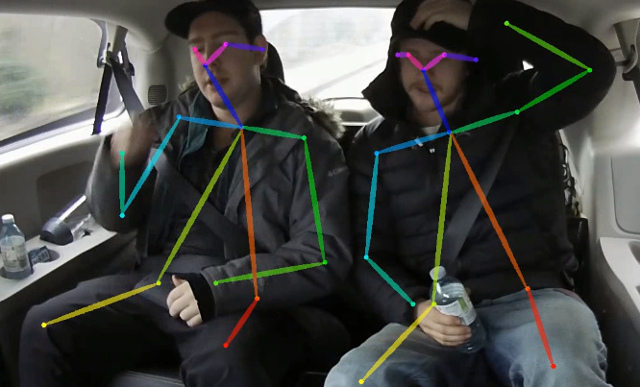

In [ ]:
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git

In [ ]:
cd /content/lightweight-human-pose-estimation.pytorch/

/content/lightweight-human-pose-estimation.pytorch


In [ ]:
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

In [ ]:
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)
            
            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

In [ ]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

## Download the Pretrained Model

In [ ]:
cd /content/pifuhd/

/content/pifuhd


In [ ]:
!sh ./scripts/download_trained_model.sh

## Run PIFuHD!


In [ ]:
# Warning: all images with the corresponding rectangle files under -i will be processed. 
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

# seems that 256 is the maximum resolution that can fit into Google Colab. 
# If you want to reconstruct a higher-resolution mesh, please try with your own machine. 

## Render the result

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
from lib.colab_util import generate_video_from_obj, set_renderer, video

renderer = set_renderer()
generate_video_from_obj(obj_path, out_img_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)

## Tips for Inputs: My results are broken!

(Kudos to those who share results on twitter with [#pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live) tag!!!!)

Due to the limited variation in the training data, your results might be broken sometimes. Here I share some useful tips to get resonable results. 

*   Use high-res image. The model is trained with 1024x1024 images. Use at least 512x512 with fine-details. Low-res images and JPEG artifacts may result in unsatisfactory results. 
*   Use an image with a single person. If the image contain multiple people, reconstruction quality is likely degraded.
*   Front facing with standing works best (or with fashion pose)
*   The entire body is covered within the image. (Note: now missing legs is partially supported)
*   Make sure the input image is well lit. Exteremy dark or bright image and strong shadow often create artifacts.
*   I recommend nearly parallel camera angle to the ground. High camera height may result in distorted legs or high heels. 
*   If the background is cluttered, use less complex background or try removing it using https://www.remove.bg/ before processing.
*   It's trained with human only. Anime characters may not work well (To my surprise, indeed many people tried it!!).
*   Search on twitter with [#pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live) tag to get a better sense of what succeeds and what fails. 


## Share your result! 
Please share your results with[ #pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live) tag on Twitter. Sharing your good/bad results helps and encourages the authors to further push towards producition-quality human digitization at home.
**As the tweet buttom below doesn't add the result video automatically, please download the result video above and manually add it to the tweet.**

In [ ]:
import IPython
IPython.display.HTML('<a href="https://twitter.com/intent/tweet?button_hashtag=pifuhd&ref_src=twsrc%5Etfw" class="twitter-hashtag-button" data-size="large" data-text="Google Colab Link: " data-url="https://bit.ly/37sfogZ" data-show-count="false">Tweet #pifuhd</a><script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>  (Don\'t forget to add your result to the tweet!)')

## Cool Applications
Special thanks to those who play with PIFuHD and came up with many creative applications!! If you made any cool applications, please tweet your demo with [#pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live). I'm constantly checking results there.
If you need complete texture on the mesh, please try my previous work [PIFu](https://github.com/shunsukesaito/PIFu) as well! It supports 3D reconstruction + texturing from a single image although the geometry quality may not be as good as PIFuHD.

In [ ]:
IPython.display.HTML('<h2>Rigging (Mixamo) + Photoreal Rendering (Blender)</h2><blockquote class="twitter-tweet"><p lang="pt" dir="ltr">vcs ainda tem a PACHORRA de me dizer que eu não sei dançar<a href="https://twitter.com/hashtag/b3d?src=hash&amp;ref_src=twsrc%5Etfw">#b3d</a> <a href="https://twitter.com/hashtag/pifuhd?src=hash&amp;ref_src=twsrc%5Etfw">#pifuhd</a> <a href="https://t.co/kHCnLh6zxH">pic.twitter.com/kHCnLh6zxH</a></p>&mdash; lukas arendero (@lukazvd) <a href="https://twitter.com/lukazvd/status/1274810484798128131?ref_src=twsrc%5Etfw">June 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script><h2>FaceApp + Rigging (Mixamo)</h2><blockquote class="twitter-tweet"><p lang="ja" dir="ltr">カツラかぶってる自分に見える <a href="https://twitter.com/hashtag/pifuhd?src=hash&amp;ref_src=twsrc%5Etfw">#pifuhd</a> <a href="https://t.co/V8o7VduTiG">pic.twitter.com/V8o7VduTiG</a></p>&mdash; Shuhei Tsuchida (@shuhei2306) <a href="https://twitter.com/shuhei2306/status/1274507242910314498?ref_src=twsrc%5Etfw">June 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script><h2>Rigging (Mixamo) + AR (Adobe Aero)</AR><blockquote class="twitter-tweet"><p lang="ja" dir="ltr">写真→PIFuHD→Mixamo→AdobeAeroでサウンド付きARを作成。Zip化してLINEでARコンテンツを共有。<br>写真が1枚あれば簡単にARの3Dアニメーションが作れる時代…凄い。<a href="https://twitter.com/hashtag/PIFuHD?src=hash&amp;ref_src=twsrc%5Etfw">#PIFuHD</a> <a href="https://twitter.com/hashtag/AdobeAero?src=hash&amp;ref_src=twsrc%5Etfw">#AdobeAero</a> <a href="https://twitter.com/hashtag/Mixamo?src=hash&amp;ref_src=twsrc%5Etfw">#Mixamo</a> <a href="https://t.co/CbiMi4gZ0K">pic.twitter.com/CbiMi4gZ0K</a></p>&mdash; モジョン (@mojon1) <a href="https://twitter.com/mojon1/status/1273217947872317441?ref_src=twsrc%5Etfw">June 17, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script><h2>3D Printing</h2><blockquote class="twitter-tweet"><p lang="ja" dir="ltr"><a href="https://twitter.com/hashtag/pifuhd?src=hash&amp;ref_src=twsrc%5Etfw">#pifuhd</a> 楽しい〜<br>小さい自分プリントした <a href="https://t.co/4qyWuij0Hs">pic.twitter.com/4qyWuij0Hs</a></p>&mdash; isb (@vxzxzxzxv) <a href="https://twitter.com/vxzxzxzxv/status/1273136266406694913?ref_src=twsrc%5Etfw">June 17, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>')